#  Kernel Least Mean Squares (KLMS) Training

##### Jackson Cornell

Implements and trains a KLMS filter for the purpose of predicting 3D accelerometer data from LFP brain recordings. Expects input data (LFP recordings, accelerometer data) to be at same sampling frequency. Performs hyperparameter tuning to select best kernel embedding size $K$, kernel size $\sigma$, and step size $\eta$. Writes computed weights to ___ file for testing.

In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np

from numpy import random
from sklearn.metrics.pairwise import euclidean_distances

## Function and class definitions
***

In [2]:
# Class implementing the kernel least mean squares (KLMS) filter
class KLMS() :
    
    ### Init Function ###
    def __init__(self, kernel_size=1, entropy_kernel_size=1, embedding_size=1, step_size=1, criterion='MSE') :
        self.kernel_size = kernel_size
        self.entropy_kernel_size = entropy_kernel_size
        self.embedding_size = embedding_size
        self.step_size = step_size
        self.criterion = criterion
        self.e = []
        self.y = []
        self.a = []
        self.x = []
        
    ### Private Functions ###
    
    # Gaussian kernel for mapping to RKHS
    def __Kernel(self, x) :
        return np.exp(-x / self.kernel_size**2)
    
    # Gaussian kernel for maximum correntropy criterion
    def __EntropyKernel(self, x) :
        return np.exp(-x**2 / self.entropy_kernel_size**2)
    
    ### Public Functions ###
    
    def get_kernel_size(self) :
        return self.kernel_size
    
    def get_entropy_kernel_size(self) :
        return self.entropy_kernel_size
    
    def get_embedding_size(self) :
        return self.embedding_size
    
    def get_step_size(self) :
        return self.step_size
    
    def get_criterion(self) :
        return self.criterion
    
    def get_error(self) :
        return np.array(self.e)
    
    def get_mse(self) :
        return np.array(self.e)**2
    
    def get_training_output(self) :
        return np.array(self.y)
    
    def get_weights(self) :
        return np.array(self.a)

    # Train filter from batch of samples
    def train(self, x, d) :
        epochs = x.size - self.embedding_size
        y = np.zeros(epochs)
        e = np.zeros(epochs)
        a = np.zeros(epochs)
        # compute kernel
        X = np.zeros((epochs, self.embedding_size))
        for j in range(epochs) :
            X[j,:] = x[j:(j + self.embedding_size)]
        D = euclidean_distances(X, X, squared=True)
        K = self.__Kernel(D)
        # stochastic gradient descent
        for i in range(epochs) :
            if (i > 0) :
                # calculate output
                if (self.criterion == 'MSE') :
                    y[i] = a[:i] @ K[:i, i]
                elif (self.criterion == 'MCC') :
                    y[i] = (a[:i] * self.__EntropyKernel(np.array(e[:i]))) @ K[:i, i] / self.entropy_kernel_size**2
            else :
                y[i] = 0
            # calculate error    
            e[i] = d[i + self.embedding_size - 1] - y[i]
            # calculate weights
            a[i] = self.step_size * e[i]
        # update parameters
        self.e = e
        self.a = a
        self.y = y
        self.x = X
        return self.e, self.y, self.a
    
    # Apply model to incoming data
    def transform(self, x) :
        epochs = x.size
        x = np.concatenate((x, np.zeros(self.embedding_size)))
        y = np.zeros(epochs)
        # compute kernel
        X = np.zeros((epochs, self.embedding_size))
        for j in range(epochs) :
            X[j,:] = x[j:(j + self.embedding_size)]
        D = euclidean_distances(self.x, X, squared=True)
        K = self.__Kernel(D)
        # apply filter
        if (self.criterion == 'MSE') :
            y = self.a @ K
        elif (self.criterion == 'MCC') :
            y = (self.a * self.__EntropyKernel(np.array(self.e))) @ K / self.entropy_kernel_size**2
        return y

In [3]:
# Train KLMS filter
def train_klms(x_train, d_train,
               x_test, d_test,
               kernel_size,
               entropy_kernel_size,
               embedding_size,
               step_size,
               criterion,
               verbose=True) :
    # parameters
    mse = []
    best_model = _
    y = _
    i = 1
    # iterate through hyperparameters
    for sigma in kernel_size :
        for k in embedding_size :
            for eta in step_size :
                for crit in criterion :
                    if (crit == 'MCC') :
                        for e_sigma in entropy_kernel_size :
                            start_time = time.time()
                            # instantiate model
                            curr_model = KLMS(kernel_size=sigma,
                                              entropy_kernel_size=e_sigma,
                                              embedding_size=k,
                                              step_size=eta,
                                              criterion=crit)
                            # train model
                            J_t, y_t, a_t = curr_model.train(x_train, d_train)
                            # test model
                            y_test = curr_model.transform(x_test)
                            end_time = time.time()
                            # save error
                            current_mse = ((y_test[:(-k+1)] - d_test[(k-1):])**2).mean()
                            mse.append(current_mse)
                            # save optimal parameters
                            if (current_mse == min(mse)) :
                                best_model = curr_model
                                y = y_test
                            # print results
                            if (verbose == True) :
                                print("Model {} execution time:".format(i),
                                      end_time - start_time,
                                      "seconds")
                                i += 1
                    else :
                        start_time = time.time()
                        # instantiate model
                        curr_model = KLMS(kernel_size=sigma,
                                          embedding_size=k,
                                          step_size=eta)
                        # train model
                        J_t, y_t, a_t = curr_model.train(x, d)
                        # test model
                        y_test = curr_model.transform(x_test)
                        end_time = time.time()
                        # save error
                        current_mse = ((y_test[:(-k+1)] - d_test[(k-1):])**2).mean()
                        mse.append(current_mse)
                        # save optimal parameters
                        if (current_mse == min(mse)) :
                            best_model = curr_model
                            y = y_test
                        # print results
                        if (verbose == True) :
                            print("Model {} execution time:".format(i),
                                  end_time - start_time,
                                  "seconds")
                            i += 1
    # return results
    return mse, best_model, y

## Import training data
***

In [4]:
# open files

# import training data

In [5]:
# split data for cross validation

In [6]:
### DELETE LATER ###

# simulate gaussian input noise
mean = 0
var = 1
L = 6002
y = np.random.normal(mean, var, L)

# simulate linear channel component
h = np.array([-0.8, 0.7])
t = np.convolve(h, y)[0:L]

# simulate memoryless non-linear channel component
q = t + 0.25*(t**2) + 0.11*(t**3)

# add gaussian noise to produce filter input
P = np.sum(q**2) / L
SNR = 10**(15/10)
xn = q + np.sqrt(P/SNR) * np.random.normal(0, 1, L)

x = xn[2:5002]
d = y[0:5000]

x_test = xn[5002:6002]
d_test = y[5000:6000]

####################

## Model training
***

In [7]:
# klms model parameters
verbose = True
kernel_size = [0.1, 1, 5, 10]
embedding_size = [5, 20]  # use ACF to figure out
step_size = [0.5]
criterion = ['MSE', 'MCC']
entropy_kernel_size = [0.1, 1, 5]

# perform hyperparameter tuning on model
mse, best_model, y = train_klms(x, d,
                                x_test, d_test,
                                kernel_size,
                                entropy_kernel_size,
                                embedding_size,
                                step_size,
                                criterion,
                                verbose=verbose)

# extract optimal parameters
best_kernel_size = best_model.get_kernel_size()
best_entropy_kernel_size = best_model.get_entropy_kernel_size()
best_embedding_size = best_model.get_embedding_size() 
best_step_size = best_model.get_step_size()
best_criterion = best_model.get_criterion()
J = best_model.get_mse()
#z = best_model.transform(w)

Model 1 execution time: 1.5251777172088623 seconds
Model 2 execution time: 1.7370483875274658 seconds
Model 3 execution time: 1.7278838157653809 seconds
Model 4 execution time: 1.769514799118042 seconds
Model 5 execution time: 1.6621599197387695 seconds
Model 6 execution time: 1.8082191944122314 seconds
Model 7 execution time: 1.812671422958374 seconds
Model 8 execution time: 1.8788633346557617 seconds
Model 9 execution time: 0.7495503425598145 seconds
Model 10 execution time: 0.933800458908081 seconds
Model 11 execution time: 0.8916995525360107 seconds
Model 12 execution time: 0.8496792316436768 seconds
Model 13 execution time: 0.7337541580200195 seconds
Model 14 execution time: 0.8984193801879883 seconds
Model 15 execution time: 0.8675832748413086 seconds
Model 16 execution time: 0.8811352252960205 seconds
Model 17 execution time: 0.7769031524658203 seconds
Model 18 execution time: 1.0991055965423584 seconds
Model 19 execution time: 0.8649759292602539 seconds
Model 20 execution time:

-----------------------------
Optimal Parameters
-----------------------------
Kernel Size:		 10
Entropy Kernel Size:	 1
Embedding Size:		 5
Step Size:		 0.5
Criterion:		 MCC
-----------------------------


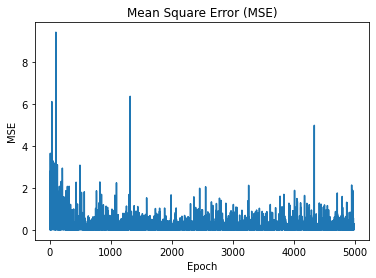

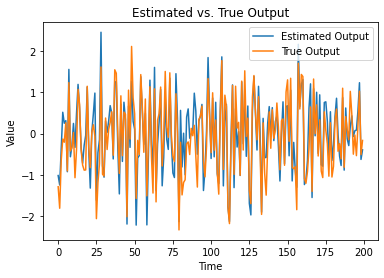

In [8]:
# display results
print("-----------------------------")
print("Optimal Parameters")
print("-----------------------------")
print("Kernel Size:\t\t", best_kernel_size)
print("Entropy Kernel Size:\t", best_entropy_kernel_size)
print("Embedding Size:\t\t", best_embedding_size)
print("Step Size:\t\t", best_step_size)
print("Criterion:\t\t", best_criterion)
print("-----------------------------")

plt.plot(J)
plt.title("Mean Square Error (MSE)")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(y[:200], label='Estimated Output')
plt.plot(d_test[(best_embedding_size - 1):(200 + best_embedding_size - 1)], label='True Output')
plt.title("Estimated vs. True Output")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# plt.plot(z, label='Estimated Output')
# plt.plot(w, label='True Output')
# plt.title("Predicted Output")
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

## Save model
***

In [9]:
# save model parameters as ___ file